# Setup

---

## Import mlwpy.py

---



In [34]:
#@title Files for Import
import_file = "mlwpy.py" #@param {type:"string"}

#import libraries
import re
import importlib

#create regex
find = re.compile(r"^(.*?)\..*")
# extract file name before .py ending
import_file_no_ext = re.search(find, import_file).group(1)

# copy file to the current notebook
!cp '/content/drive/MyDrive/Colab Notebooks/imports/{import_file}' .
# import module
module = importlib.import_module(import_file_no_ext)

# is there an __all__? if so import all
if '__all__' in module.__dict__:
    names = module.__dict__['__all__']
else:
    # otherwise import all names that don't begin with _
    names = [x for x in module.__dict__ if not x.startswith('_')]

# now bring them in
globals().update({k: getattr(module, k) for k in names})

print(f'Imported file: {import_file_no_ext}.py')

# set matplotlib to display inline
%matplotlib inline

Imported file: mlwpy.py


## Font Settings

---


In [35]:
# save default font settings
IPython_default = plt.rcParams.copy()

# set fonts / set text size
#@title matplotlib font settings
small_text = 15 #@param {type:"integer"}
medium_text = 26 #@param {type:"integer"}
large_text = 28 #@param {type:"integer"}
line_marker_size = 3.5 #@param {type:"slider", min:0, max:10, step:0.5}
legend_shadow = True #@param {type:"boolean"}
fig_width =   10 #@param {type:"number"}
fig_height =  8 #@param {type:"number"}
sns_style = "ticks" #@param ["darkgrid", "whitegrid", "dark", "white", "ticks"]
axis_grid = True #@param {type:"boolean"}
sns_palette = "deep" #@param ["pastel", "muted", "bright", "deep", "colorblind", "dark"]

import matplotlib.pyplot as plt
import seaborn as sns

# restore defaults
plt.rcdefaults()

plt.rcParams['axes.labelsize']   = small_text
plt.rcParams['axes.titlesize']   = small_text
plt.rcParams['xtick.labelsize']  = small_text
plt.rcParams['ytick.labelsize']  = small_text
plt.rcParams['legend.fontsize']  = small_text
plt.rcParams['legend.shadow']    = legend_shadow
plt.rcParams['lines.markersize'] = line_marker_size
plt.rcParams['figure.figsize']   = (fig_width, fig_height)
plt.rcParams['font.size']        = small_text

# seaborn parameters
sns.set_style(sns_style, {"axes.grid": axis_grid})
sns.set_palette(sns_palette)


## Set word-wrap and notebook font sizes

---


In [36]:
# enable wordwrap
#https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
    td,th,p {
        font-size: 18px
    }
    .rendered_html {
        font-size: 18px; 
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)


# Chapter 10 - Manual Feature Engineering: Manipulating Data for Fun and Profit

---


## Load iris data and conver to dataframe

---

In [37]:
iris = datasets.load_iris()
(iris_train,     iris_test,
 iris_train_tgt, iris_test_tgt) = skms.train_test_split(iris.data,
                                                       iris.target,
                                                       test_size=.25)
# remove units ' (cm)' from names
iris.feature_names = [fn[:-5] for fn in iris.feature_names]

# dataframe for convenience
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target_names[iris.target]


## 10.1 Feature Engineering Terminology and Motivation

---

*Feature engineering* refers to manipulation--addition, deletion, combination, and mutation, of features.

Features are attribute-value pars, so we could add or remove columns from our data table and modify values within columns. Feature engineering.

* *Scaling* and *normalization* mean adjusting the range and center of data to ease learning and improve the interpretation of results. The *diabetes* dataset in `sklearn` comes pre-*standardized*, which is one form of scaling.

* *Filling missing values* Real-world datasets can be missing values due to the difficulty of collecting *complete* datasets and errors in the data collection process. Missing values can be filled based on expert knowledge, heuristics, or some machine learning techniques.

* *Feature selection* - removing features that are unimportant, redundant, or counterproductive to learning.

* *Feature coding* - Choosing a set of symoblic values to represent different categories. An example is exapdning the *WithPartner* column into two columns represented by true and false falues.

* *Feature construction* - creates new features from other features, like creating an area column from width and length columns.

* *Feature extraction* - moving from low-level features that are unsuitable for learning, to higher-level features which *are* useful for learning.  This is often valueable when we are working with images or text and need to convert these into tabular row-column, example-feature formats. Feature extraction differs with feature construction in the complexity of the transformations, though they are conceptually the same thing.


### 10.1.1 Why Engineer Features?

---

### 10.1.2 When Does Engineering Happen?

---

### 10.1.3 How Does Feature Engineering Occur?

## 10.2 Feature Selection and Data Reduction: Taking out the Trash


## 10.3 Feature Scaling

---

Rescaling means translating the values so that the extremes are different and the intermediate values are moved in some consistentn way. Recentering means that we translate the values so the extremes are different and the intermediate values are moved in some consistent way (same thing?).

Often, rescaling results in recentered data. There are two major ways of rescaling: (a) changing the data on a *fixed* scale or (b) changing the values with respect to some statistic computed from the data.

Conferting between Fahrenheit and Celsius is an example of fixed rescaling.  The formula is $ C = \frac{5}{9}F - 17.7 $, which is the same as $y = mx + b$. Converting values with a linear formula stretches and shifts the values. *m* is responsible for stretching and *b* is responsible for shifting.


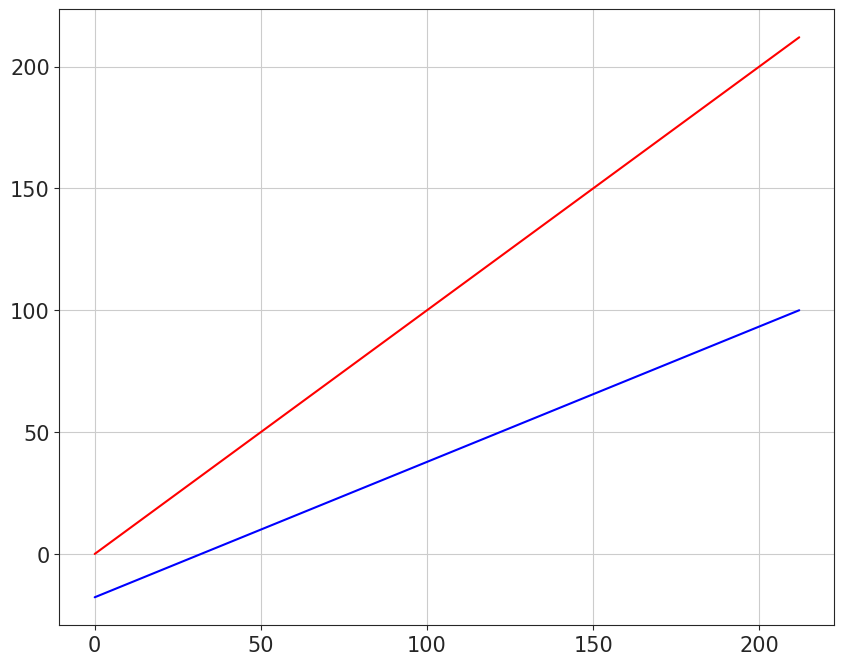

In [38]:
fig, ax = plt.subplots(1,1)
f_temps = np.linspace(0, 212, 100)
c_temps = (5/9) * (f_temps - 32)
plt.plot(f_temps, f_temps, 'r',  # F -> F
         f_temps, c_temps, 'b'); # F -> C

The upper red line is compressed vertically from 0 to 212 to around -18 to 100 on the lower blue line. The central value moves from 106 to 59. Outside of unit conversions like converting Celsius to Fahrenhit or meters to feet, the most common *fixed* scalings are mapping {min, max} values to {0, 1} or to {-1, 1} and spreading the other values out evenly between them.

*Standardization* is a bit trickier. Instead of stretching out from the source to the target based on a fixed, prior value, like $\frac{5}{9}$, it compresses values based on the spread, measured by the variance or standard deviation--of the source values. We exaplin the difference with a graphic. We use `sklearn`'s `StandardScaler` to do the heavy lifting. `fit_transform` evaluates the training data *and* modifies it in one go. It is similar to our usual `model.fit().predict()` chanining, except it does not use a separate target in the `fit()` step. It learns the case, a mean and a standard deviation, and then applies itself to them. After being fit, it can also transform testing data.

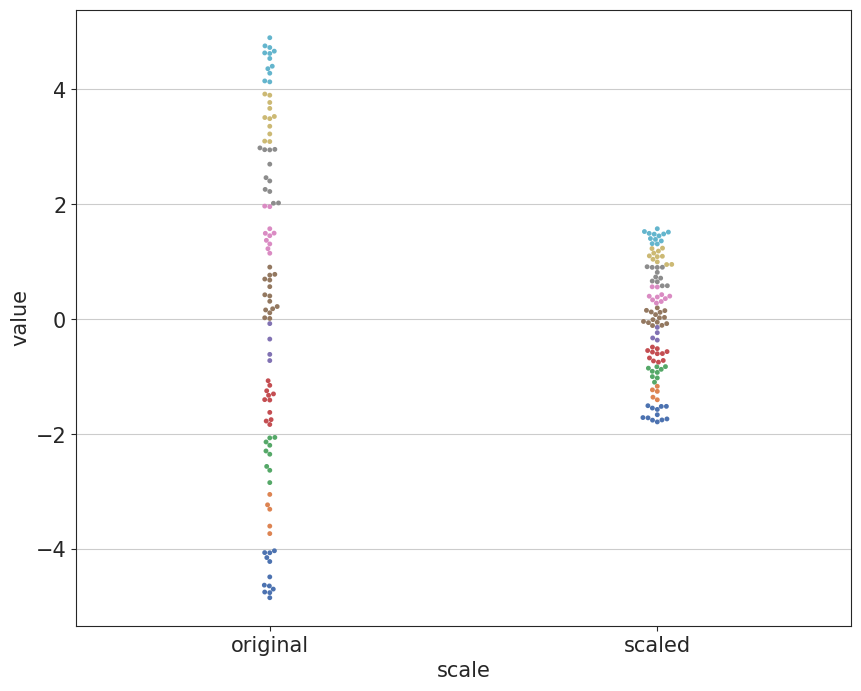

In [39]:
fig, ax = plt.subplots(1,1)
original = np.random.uniform(-5, 5, 100)
scaled = skpre.StandardScaler().fit_transform(original.reshape(-1,1))[:,0]
bins = np.floor(original).astype(np.uint8) + 5

df = pd.DataFrame({'original':original,
                   'scaled':scaled,
                   'hue':bins})
df = pd.melt(df, id_vars='hue', var_name='scale')

sns.swarmplot(x='scale', y='value', hue='hue', data=df, s=line_marker_size).legend_.remove()

Here, the unit of measurement is not Fahrenheit or Celsius, it's units of the *standard deviation*. The standard deviation tells us the spread of our data. The more spread-out the data is, the bigger the standard deviation is. We are *still* on a linear scale after we standardize. Here's the formula: $$scaled = \frac{orig-mean(orig)}{stddev(orig)} = \frac{1}{stddev(orig)}orig - \frac{mean(orig)}{stddev(orig)}.$$
 
There's a hidden $y = mx+ b$ in there. The new center of the data is zero. 

Curiously, standardization does not change the overall shape of the data. In the example above, we had data from a uniform or flat-ish distribution. When we standardize it, it is still uniform. The shape has relatively flat sides. It is now more compressed. If the data looks like a two-humped camel and we standardize it, it would *still* have two humps. Basically, we can evenly stretch of squeeze the graph of the data, but we can't distort it more than that.

Let's look into the *how* of scaling. Here are simple examples of `MinMaxScaler` and `StandardScaler`. To follow the example points as they move around, we color them by their percentile bin. We use the Pandas `cut` method to do this. It is similar to the encoding technique we used when we made our piecewise constant regression model in Section 9.3. Here, we make use of Pandas *categorical* capabilities to create a coloring value:

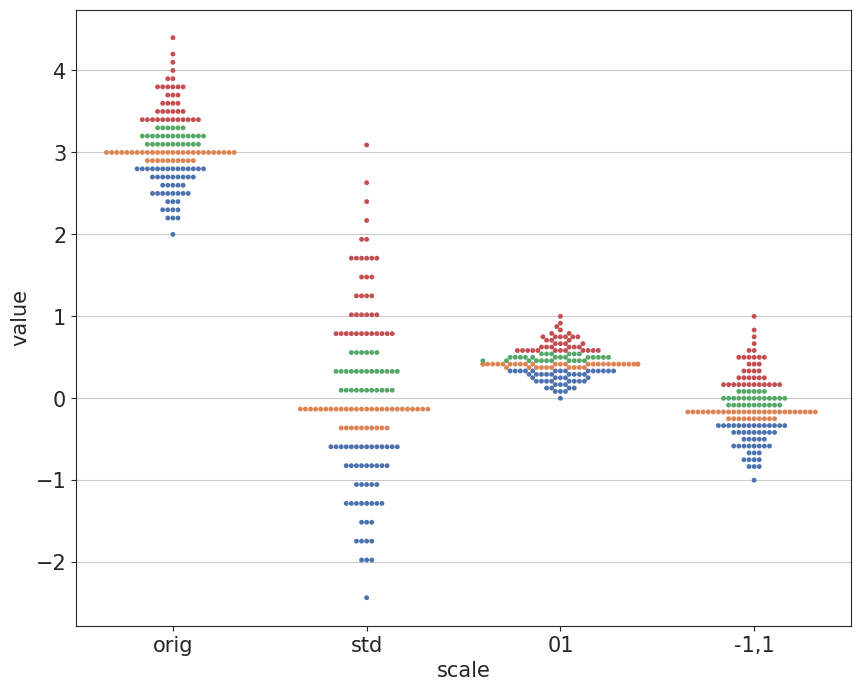

In [40]:
fig, ax = plt.subplots(1,1)
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
bins = pd.cut(iris_df['sepal width'],
              np.percentile(iris_df['sepal width'],
                            [25,50,75,100])).cat.codes

df = pd.DataFrame({'orig':iris_df['sepal width'],
                   'hue':bins})

scalers = [('std', skpre.StandardScaler()),
           ('01', skpre.MinMaxScaler()),
           ('-1,1', skpre.MinMaxScaler((-1,1)))]

for name, scaler in scalers:           
  # ugly: [[]] to keep 2D for sklearn
  #       reshape(-1) to go back to 1D for seaborn :(
  df[name] = scaler.fit_transform(df[['orig']]).reshape(-1)

df = pd.melt(df, id_vars='hue', var_name='scale')
sns.swarmplot(x='scale', y='value', hue='hue', s=line_marker_size, data=df).legend_.remove()

The most common motivation for rescaling is that we don't want arbitrary measurement scales to influence our outcomes. If we measure someone's height in meters, instead of nanometers, the values will be much smaller, one meter is an awful lot of nano-meters. Another example is if we are measuring household income and the number of cars per household, since these values ahve different weights we want to place them on a common scale.

# 10.4 Discretization

Discretization is the process of sortin a range of continuous values into some finite, or discrete, buckets of values. We saw this when implementing piecewise constant regression. Discretization also shows up as part of decision tree value splits: $height \gt 5'7''$ is either true or false.

There are a number of *automated* methods for discretizing data; some look at the relationship between a feature's values, the *ideal* split points to break those features at, and the value of those breaks to good classification. It is crucial the methods be used inside of cross-validation to prevent overfitting on the training data. Sufficiently advanced discretization strategies are micro-learners of their own. Imagine if they could discretize right into the correct bins. Let's consider some *manual* appraoches to discretization with the *iris* data.

In [41]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target_names[iris.target]
display(iris_df.iloc[[0,50,100]])

,sepal length,sepal width,petal length,petal width,species
0,5.1000,3.5000,1.4000,0.2000,setosa
50,7.0000,3.2000,4.7000,1.4000,versicolor
100,6.3000,3.3000,6.0000,2.5000,virginica


Looking at a smoothed plot of the sepal lengths, we see it is a pretty well-behaved bump.

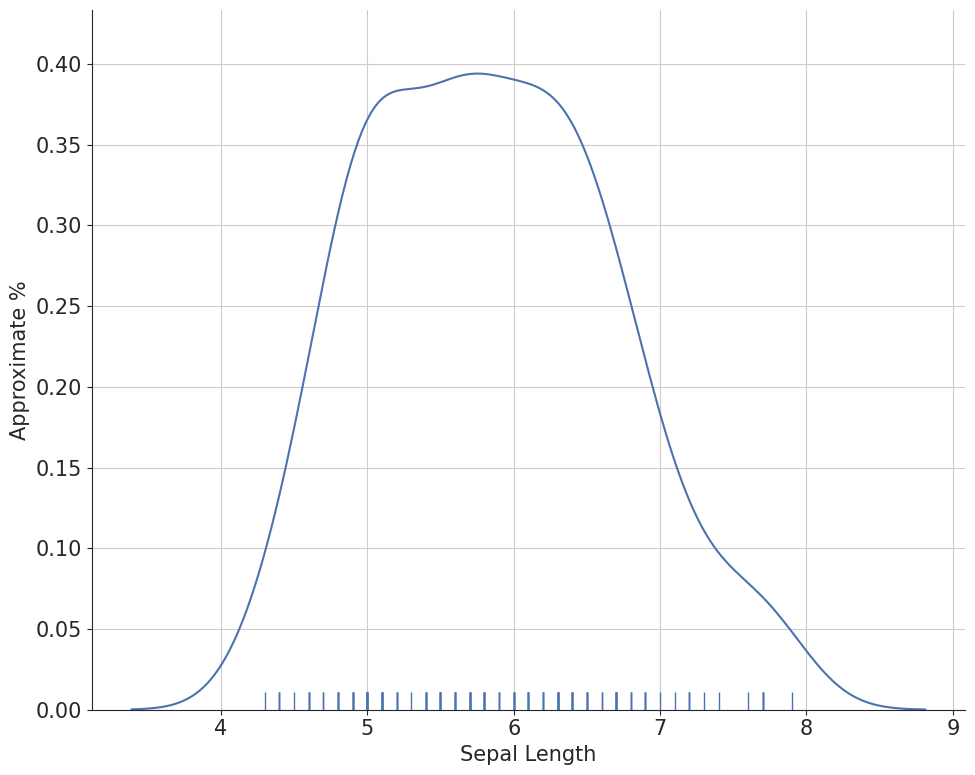

In [42]:
#@title SNS Displot
bw_adjust = 1 #@param {type:"slider", min:0, max:10, step:0.1}
#fig, ax = plt.subplots(1,1)
#plt.subplots(1,1,figsize=(12,9))
ax = sns.displot(iris_df['sepal length'], bw_adjust=bw_adjust, 
                 rug=True, kind='kde', height=8, aspect=10/8)
ax.set(xlabel='Sepal Length', ylabel='Approximate %')
plt.show()

## Discretize `preprocessing.binarize()`

A simple way to discretize is to break the values into *low* and *high* at the mean or median.

In [43]:
# apply binary threshold to numeric with sklearn is tricky
column = iris_df[['sepal length']] # keep 2Dness because sk complains
col_mean = column.mean().values    # and sk fails with Series/DF
both = column.copy()
both['> Mean'] = skpre.binarize(column, col_mean).astype(np.bool)

print('Column Mean:', col_mean)
display(both.iloc[[0,50,100]])

Column Mean: [5.8433]


,sepal length,> Mean
0,5.1000,False
50,7.0000,True
100,6.3000,True


## Discretize `pd.cut()`

We can do the same discretization using the `pd.cut` function we showed a minute or two ago.

In [44]:
sep_len_series = iris_df['sepal length']
breaks = [sep_len_series.mean(),
          sep_len_series.max()]          

# ugly to extract
print(pd.cut(sep_len_series, breaks).cat.codes[[0, 50, 100]])

0     -1
50     0
100    0
dtype: int8


## Discretize `np.where()`

Going to raw `np` results in a fairly readable solution that involves minimal behind-the-scenes magic.

In [45]:
# an easy button:
np.where(column > column.mean(), True, False)[[0,50,100]]

array([[False],
       [ True],
       [ True]])

Only our prediction problem can tell us how it best to partition the data. However, with the sepal length example, because most of the examples occur in the middle together, it might be best to partition the feature into short, medium, and long buckets, with *most* of the examples falling into the medium bucket.

We can always cross-validate thresholds and compare. If we have no source of expert information, we might try a range of split point possibilities and cross-validate them to make sure we don't overfit.

Which technique should you use? The answer is *it depends*. If you have more complex numerical data, NumPy might be a good option. There's a bit more of a tradeoff with the Pandas and `sklearn` options. The Pandas option isn't going to be super convenient to place inside of a cross-validation loop. The `sklearn` method will plug directly into cross-validation using pipelines. If you need to do data exploration and processing to come up with the split points, stick with Pandas.


# 10.5 Categorical Coding

So far, we have been predicting the species from numerical measurements in the *iris* dataset. We can rearrange the data and do other learning tasks. For example, imagine we want to predict petal length from the other features, including the species. We take the species as a *known* input feature and the petal length as an *unknown* target. Here's what the data looks like:

In [46]:
new_iris_df = pd.DataFrame(iris_df, columns=['petal length',
                                             'petal width',
                                             'species'])
new_iris_df.columns = pd.MultiIndex([['input ftrs', 'target ftr'],
                                      new_iris_df.columns],
                                      [[1,0,0], [0,1,2]])
new_iris_df.sort_index(axis='columns', inplace=True)
display(new_iris_df.iloc[[0,50,100]])
                                      
                                      

input ftrs                       target ftr
             petal width     species         petal length
0                 0.2000      setosa               1.4000
50                1.4000  versicolor               4.7000
100               2.5000   virginica               6.0000

Species does not have a direct numerical interpretation. There is not a defined ordering that we can use to say setosa = 1 < versicolor = 2. We *could* use numbers to represent categories but if we pass this column to linear regression, what would it mean for a species coefficient to be multiplied by these different values? We would be treating the *categories* as numerical values when they are really just class identifiers. We *don't* want a numerical difference of `1` to be interpreted as adding or subtracting anything from a predicted petal length.

The general technique for encoding discrete data is called *coding categorical variables*. We examine it in a broader context in a few minutes. Let's start with the old-school technique of *one-hot coding*. This translates a single column with multiple values into multiple columns with one, and only one, *on* value. The *on* value for an example is usually a binary 1 (or True) with the other column values being 0 (or False). Here are the iris species in a one-hot encoding: 

In [47]:
# start with category numbers
print('Numerical categories:',
      iris.target[[0, 50, 100]], sep='\n')

# produces sparse representation
sparse = skpre.OneHotEncoder().fit_transform(iris.target.reshape(-1,1))

# densify it
print('One-hot coding:',
      sparse[[0,50,100]].todense(), sep='\n')


Numerical categories:
[0 1 2]
One-hot coding:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


`OneHotEncoder` requires numerical inputs. It is not happy with strings. It also requires a 2D input, which is why we called `reshape` above. 

`OneHotEncoder` produces many zeros in the result. So `sklearn` is clever and stores the data in a compressed format that deals well with *sparsity*--a technical term for data with lots of zeros. Instead of recording values everywhere, it records just the nonzero entries and assumes everything else is zero.

Some learning methods can work efficiently with sparse data; they know that many values are zero and are smart about not doing extra work. If we want to see the data in its usual, complete form, we have to ask to make it dense. When we fill out the sparse form, we have a table that is a bit like Swiss cheese: it has lots of holes in it. We have to fill the holes, values that were assumed to be zero, in with *actual* zeros. Then, there is a solid, dense, table with entries everywhere. We do that with the `.todense()` call in the last line.

We can also perform one-hot encoding with `pandas`. One benefit is that we can ask it to give nice labels to the one-hot columns.

In [48]:
# can use drop_first to get treatment coding
# can request sparse storage
encoded = pd.get_dummies(iris_df, prefix='is')
encoded.iloc[[0,50,100]]

,sepal length,sepal width,petal length,petal width,is_setosa,is_versicolor,is_virginica
0,5.1000,3.5000,1.4000,0.2000,1,0,0
50,7.0000,3.2000,4.7000,1.4000,0,1,0
100,6.3000,3.3000,6.0000,2.5000,0,0,1


We can `merge` the one-hot species with the original data for fun and profit. We may want to visualize the relationship between the encoding and the original species values. Here goes:


In [49]:
# splicing dataframes together by merging
# recall `iris.target` is in terms of 0, 1, 2, not symbolic (setosa, etc).
encoded_species = pd.get_dummies(iris.target)

encoded_df = pd.merge(iris_df, encoded_species,
                      right_index=True, left_index=True)
encoded_df.iloc[[0,50,100]]

,sepal length,sepal width,petal length,petal width,species,0,1,2
0,5.1000,3.5000,1.4000,0.2000,setosa,1,0,0
50,7.0000,3.2000,4.7000,1.4000,versicolor,0,1,0
100,6.3000,3.3000,6.0000,2.5000,virginica,0,0,1


## 10.5.1 Another way to Code and the Curious Case of the Missing Intercept

Here's another way to achieve one-hot coding. In the statistical world, the one-hot coding goes by the names of *treatment* or *dummy coding*. `patsy` is a nice system that allows us to specify a number of feature engineering and modeling ideas in a convenient way. here's a long-hand version we'll use in a minute:

In [50]:
import patsy.contrasts as pc

levels = iris.target_names
coding = (pc.Treatment(reference=0)
            .code_with_intercept(list(levels)))
print(coding)

ContrastMatrix(array([[1., 0., 0.],
                      [0., 1., 0.],
                      [0., 0., 1.]]),
               ['[setosa]', '[versicolor]', '[virginica]'])


We can press the easy button on the `patsy` method.


In [51]:
encoded = patsy.dmatrix('species-1',
                        iris_df,
                        return_type='dataframe')
display(encoded.iloc[[0,50,100]])

,species[setosa],species[versicolor],species[virginica]
0,1.0000,0.0000,0.0000
50,0.0000,1.0000,0.0000
100,0.0000,0.0000,1.0000


What's happening with that `-1` in `'species-1'`? Let's see what happens when we leave it out.

In [52]:
encoded = patsy.dmatrix('species',
                        iris_df,
                        return_type='dataframe')
display(encoded.iloc[[0,50,100]])

,Intercept,species[T.versicolor],species[T.virginica]
0,1.0000,0.0000,0.0000
50,1.0000,1.0000,0.0000
100,1.0000,0.0000,1.0000


We get *two* features coded explicitly *and* we get a column of all ones under the name *Intercept*. Why do we have to do the `-1` to get the simple result? Why does the `dmatrix` for `species` give us a column of ones *and*, seemingly!, ignore one of the species (there's no column for *setosa*)? We come back to this in a moment.

### 10.5.1.1 Patsy Models

Let's point a flashlight at what just happened. We were building design matrices, `dmatrix` critters, with two main elements: (1) some specification of a modeling idea and (2) the data we want to run through the model. A design matrix tells us how we get from raw data to the form of the data we want to run through the underlying number-crunching of a modeling process.

We might specify we want to predict petal length from petal width and species. We could write this specification as `'petal_length ~ petal_width + C(species, Treatment)'`. The specification says to run a linear regression with the left-hand side of the tilde `~` as the target and the RHS terms as the input features. The `C()` indicates we want to encode the `species` before running the linear regression. Having spaces in the names complicates matters slightly, but we fix that in a moment. Here's a quick reference of basic things we can do with `patsy` formulas:

* `tgt ~ ftr_1 + ftr_2 + ftr_3`: model `tgt` from the RHS features
* `tgt ~ Q('ftr 1') + Q('ftr 2') + Q('ftr 3')`: `Q`uote funky najmes.
* `tgt ~ ftr_1 + C(cat_ftr, Some_Coding)`: model `tgt` on `ftr_1` and the `C`ategeroically encoded `cat_ftr`.
* `tgt ~ ftr_1 -1`: model `tgt` on `ftr_1` *without* an intercept. By default, the formulas include an intercept: we have to remove it by hand. We can also remove features from the RHS: `tgt ~ ftr_1 + ftr_2 - ftr_1` is equivalent to `tgt ~ ftr_2`. There are useful cases for feature removal.

Now, let's investigate what happens with including or not including certain variable codings. To do so, we need some trivial data we can process in our heads. Here we go:

In [53]:
import pandas as pd

In [54]:
pet_data = pd.DataFrame({'pet' :['cat', 'cat', 'dog'],
                         'cost':[20.0, 25.0, 40.0]})

pet_df = pd.get_dummies(pet_data)
display(pet_df)

,cost,pet_cat,pet_dog
0,20.0000,1,0
1,25.0000,1,0
2,40.0000,0,1


In this example, the cat costs are 20 and 25. The single dog example has a cost of 40. Make a quick mental note that the average cat cost is 22.50.

### 10.5.1.2 Model (Seemingly) without Intercept

---

Let's take a look at the knob values set on our factory machine. After we `fit`, linear regression will have chosen particular knob values, the *w*s or *m, b*. 

Below, you might notice that I snuck a `fit_intercept=False` into the linear regression constructor. It is intimately tied to the default `dmatrix` having a column of all ones and *not* coding all three species explicitly. Keep in mind that we didn't explicitly fit a `b` term (the constant or intercept).

In [55]:
def pretty_coeffs(sk_lr_model, ftr_names):
    ' helper to display sklearn results in a nice dataframe '
    lr_coeffs = pd.DataFrame(sk_lr_model.coef_,
                             columns=ftr_names,
                             index=['Coeff'])
    lr_coeffs['intercept'] = sk_lr_model.intercept_
    return lr_coeffs

Let's do a bit of data massaging to make our modeling step happy:

In [56]:
# massage
sk_tgt = pet_df['cost'].values.reshape(-1,1)
print(sk_tgt)
sk_ftrs = pet_df.drop('cost', axis='columns')
print(sk_ftrs)

# build model
sk_model = (linear_model.LinearRegression(fit_intercept=False)
                        .fit(sk_ftrs, sk_tgt))
print(sk_model.coef_)
print(sk_model.intercept_)
display(pretty_coeffs(sk_model, sk_ftrs.columns))

[[20.]
 [25.]
 [40.]]
   pet_cat  pet_dog
0        1        0
1        1        0
2        0        1
[[22.5 40. ]]
0.0


,pet_cat,pet_dog,intercept
Coeff,22.5000,40.0000,0.0000


We did not fit an intercept, which is the equivalent to fixing its value at zero. Regarding the interpretation of the `pet` entries. One, and only one, of the two feature values (for *pet_cat* and *pet_dog*) is not zero. Basically, we pick one of those two columns, and the result chooses our cost.

Here's another way to generate *the same* model and knob settings.

In [57]:
import statsmodels as small_text
import statsmodels.formula.api as smf

# patsy formula that explicitly removes an intercept
formula = 'cost ~ pet - 1'
sm_model = smf.ols(formula, data=pet_data).fit()
display(pd.DataFrame(sm_model.params).T)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,pet[cat],pet[dog]
0,22.5000,40.0000


The two methods work out to the same coefficients. Let's go back to the question of the missing intercept. We left it out with `fit_intercept=False` in the `sklearn` example. If you play around with the `patsy` formulas, you'll find it is difficult to get an explicit three-column dummy coding for the species *and* a column of all ones for the intercept.

* Why does coding a categorical variable, by default, appear to leave one variable value out?
* Why does the default formula include an intercept?

#### 10.5.1.3 Model with Definite Intercept

Let's recreate the `sklearn` model, this time *with* an intercept

In [58]:
sk_tgt = pet_df['cost'].values.reshape(-1,1)
print(sk_tgt)
sk_ftrs = pet_df.drop('cost', axis='columns')
sk_model = (linear_model.LinearRegression() # fit_intercept=True by default!
                        .fit(sk_ftrs, sk_tgt))
display(pretty_coeffs(sk_model, sk_ftrs.columns))

[[20.]
 [25.]
 [40.]]


,pet_cat,pet_dog,intercept
Coeff,-8.7500,8.7500,31.2500


Let's do *the same* model building with `patsy` and `statsmodels`. We have to do some trickery to convince statsmodels to (1) use the fully explicit, one-hot coding for the pets and (2) *also* use a column of all ones. We do this by (1) `pet - 1` to code the pets with both cats and dogs and (2) we use an artificial columns of `ones` to force an intercept.

In [59]:
pet_data_p1 = pet_data.copy()   # make a copy of the data
pet_data_p1['ones'] = 1.0       # manual +1 trick

# remove coding intercept .... add manual ones == add manual intercept
formula = 'cost ~ (pet - 1) + ones'
sm_model = smf.ols(formula, data=pet_data_p1).fit()
display(pd.DataFrame(sm_model.params).T)

,pet[cat],pet[dog],ones
0,1.6667,19.1667,20.8333


Something looks wrong, the coefficiets are different. Let's look at the predictions from both models:

In [60]:
# row-slicing is annoying, but have to get to single-D things
# and .flat gives a warning in the DF constructor
df = pd.DataFrame({'predicted_sk' : sk_model.predict(sk_ftrs)[:,0],
                   'predicted_sm' : sm_model.predict(pet_data_p1),
                   'actual'       : sk_tgt[:,0]})
display(df)

,predicted_sk,predicted_sm,actual
0,22.5000,22.5000,20.0000
1,22.5000,22.5000,25.0000
2,40.0000,40.0000,40.0000


The predictions are the same, what on Earth is going on?

#### 10.5.1.4 Solving the Riddle

Let's look at what happens under the hood when we specify a `pet` formula without an intercept. Here's our data including the column of ones:

In [61]:
display(pet_data_p1)

,pet,cost,ones
0,cat,20.0000,1.0000
1,cat,25.0000,1.0000
2,dog,40.0000,1.0000


The encoding for that data--without an intercept from the categorical coding--gives us

In [62]:
print('pet - 1 coding')
print(patsy.dmatrix('pet -1', data=pet_data_p1))

pet - 1 coding
[[1. 0.]
 [1. 0.]
 [0. 1.]]


Looking at the rows, we can vary there is only one "on" value for each example:

In [63]:
# what happens when we add up the coding columns
print('column sum:')
full_coding = patsy.dmatrix('pet - 1',
                            data=pet_data_p1,
                            return_type='dataframe')
display(pd.DataFrame(full_coding.sum(axis='columns')))

column sum:


,0
0,1.0000
1,1.0000
2,1.0000


If we add up the columns of the fully explicit coding that has columns for both pets, we get a column of all ones. Also, both of our models--the `sklearn` has `fit_intercept=True` by default and our `statsmodels` has the explicit column of ones--*already* have a column of ones in them. Therefore, we have a redundant column of ones buried in our data. The redundancy is why there are two different but predictively equivalent answers to the regression models with intercepts. When we remove the intercept but keep the full coding, we *still* have an intercept-like term from the sum of the coding columns.

If a linear combination of some columns is equal to a linear combination of other columns, there is redundancy. Then, we can't accuractely get one and only one answer for our linear regression coefficients: there are an infinite number of equally correct answers. We can add a ittle bit to one coefficient and subtract a little bit from another and they will balance out. This did not seem to be much of a problem for us in terms of predictions. The redundancy issue is called *collinearity* and it is more of a concern when moving from the level of prediciton and enter the realm of statistical and causal reasonsing. We are sweeping these issues under the rug in this book. however, the issues are precisely why `statsmodels` makes you go far out of your way to include both full coding and an explicit intercept.

# 10.6 Relationships and Interactions

Let's create a simple table of examples for the *xor function.* *xor* is a Boolean function that is true only when one or the othe, but not both inputs is true. Here's the data:

In [64]:
xor_data = [[0,0,0],
            [0,1,1],
            [1,0,1],
            [1,1,0]]
xor_df = pd.DataFrame(xor_data,
                      columns=['x1','x2','tgt'])
display(xor_df)            

,x1,x2,tgt
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


If we try to model *xor* with a simple linear classifier, things don't work out well. We get problems predicting *in-sample* on the training set--we haven't even seen any novel *testing* data yet.

In [65]:
model = linear_model.LogisticRegression().fit(xor_df[['x1', 'x2']],
                                              xor_df['tgt'])
model.predict(xor_df[['x1', 'x2']])

array([0, 0, 0, 0])

How can we be so bad? Let's look at a graph of the data values colored by their output.


In [66]:
display(xor_df)

,x1,x2,tgt
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


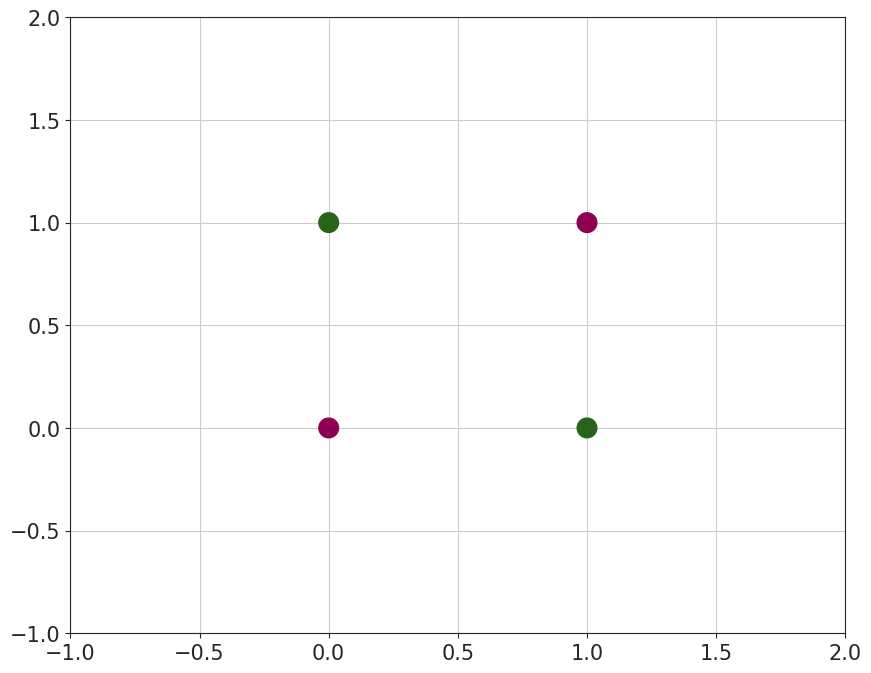

In [69]:
colors = cm.rainbow(np.linspace(0,1,len(xor_df['tgt'])))

fig, ax = plt.subplots(1,1)
ax.scatter('x1', 'x2', data=xor_df, s=200, c='tgt', cmap='PiYG')
ax.set_xlim(-1,2)
ax.set_ylim(-1,2)
plt.show()

It is fundamentally impossible to use a single line to separate these points and keep them with their like classes only. At a minimu, we need two lines to fence off points on one diagonal from points on the other diagonal. What if we create a clever feature?

In [70]:
xor_df['new'] = (-1) ** xor_df['x1'] * (-1) ** xor_df['x2']
xor_df                             

,x1,x2,tgt,new
0,0,0,0,1
1,0,1,1,-1
2,1,0,1,-1
3,1,1,0,1


Here's, things start looking nice: even a super simple rule, `xor_df['new'] < 0 == True`, will give us our target. Here's what happens:

In [71]:
model = linear_model.LogisticRegression().fit(xor_df[['new']],
                                              xor_df['tgt'])
model.predict(xor_df[['new']])

array([0, 1, 1, 0])

Sometimes, we need to invent a new vocabulary, constructed columns like `new`, to enable our learning systems to *learn*.

### 10.6.2 Interaction

A specific type of constructed feature is an *interaction* between existing features. There are two major ways that features interact: (1) by working together like a key in a dictionary that selects a class or target value and (2) by acting together based on their *product* instead of their sum. Multiple degrees of interaction can include more and more features.

Here, we consider two-way interactions between numerical features--all pairs of numerical features--with `sklearn`:

In [72]:
# parameters:
# degree: degree of terms
# interaction_only: no x**2, only x*y (and x,y)
# include_bias: constant term
quad_inters = skpre.PolynomialFeatures(degree=2,              # degree of terms
                                       interaction_only=True, # no x**2, only x*y
                                       include_bias=False)    # constant term
subset = iris_df.loc[[0, 50, 100], ['sepal length', 'sepal width']]
new_terms = pd.DataFrame(quad_inters.fit_transform(subset),
                         index=[0, 50, 100])
new_terms.set_axis(['sep length', 'sep width', 'sep area'],
                   axis=1, inplace=True)

# note: creating the interaction *also*
# includes the base terms in the interaction
display(new_terms)                                       
                                       

,sep length,sep width,sep area
0,5.1000,3.5000,17.8500
50,7.0000,3.2000,22.4000
100,6.3000,3.3000,20.7900


#### 10.6.2.1 Interactions via Patsy Formulas

Now we can get a big win from using `patsy` formulas. Patsy lets us specify interactions with either `:` or `*`. The difference is that `:` only includes the interaction, `sepal_width * sepal_length`, between the two, like `interaction_only=True` in `sklearn.preprocessing.PolynomialFeatures`.


In [74]:
design_df = patsy.dmatrix("Q('sepal length'):Q('sepal width') - 1",
                          data=iris_df.iloc[[0,50,100]],
                          return_type='dataframe')
design_df


,Q('sepal length'):Q('sepal width')
0,17.8500
50,22.4000
100,20.7900
